<a href="https://colab.research.google.com/github/kartikay-99k/Cough-detector-app/blob/master/NoobModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip '/content/drive/My Drive/cough_final.zip'

Archive:  /content/drive/My Drive/cough_final.zip
  inflating: cough_final/1-100032-A-0.png  
  inflating: cough_final/1-100038-A-14.png  
  inflating: cough_final/1-100210-A-36.png  
  inflating: cough_final/1-100210-B-36.png  
  inflating: cough_final/1-101296-A-19.png  
  inflating: cough_final/1-101296-B-19.png  
  inflating: cough_final/1-101336-A-30.png  
  inflating: cough_final/1-101404-A-34.png  
  inflating: cough_final/1-103298-A-9.png  
  inflating: cough_final/1-103995-A-30.png  
  inflating: cough_final/1-103999-A-30.png  
  inflating: cough_final/1-104089-A-22.png  
  inflating: cough_final/1-104089-B-22.png  
  inflating: cough_final/1-105224-A-22.png  
  inflating: cough_final/1-110389-A-0.png  
  inflating: cough_final/1-110537-A-22.png  
  inflating: cough_final/1-115521-A-19.png  
  inflating: cough_final/1-115545-A-48.png  
  inflating: cough_final/1-115545-B-48.png  
  inflating: cough_final/1-115545-C-48.png  
  inflating: cough_final/1-115546-A-48.png  
  inflat

In [0]:
import pandas as pd
import numpy as np
data = pd.read_csv('/content/esc50.csv')

In [2]:
data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [0]:
data.drop(['fold','target','esc10','src_file','take'],axis=1,inplace=True)

In [0]:
for i in range(2000) : 
  if data.at[i,'category'] == 'coughing' : data.at[i,'label'] = 1
  else : data.at[i,'label'] = 0

In [0]:
data.drop('category',axis=1,inplace=True)

In [6]:
data.label.value_counts()

0.0    1960
1.0      40
Name: label, dtype: int64

In [0]:
data.filename=data.filename.apply(lambda x: x.replace('wav','png'))

In [0]:
X=data.drop('label',axis=1)
y=data.label
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1)

In [0]:
image_paths = '/content/cough_final/' + X_train.filename.to_numpy()

In [15]:
image_paths

array(['/content/cough_final/1-59324-A-21.png',
       '/content/cough_final/3-163288-A-1.png',
       '/content/cough_final/3-20861-A-8.png', ...,
       '/content/cough_final/1-24524-A-19.png',
       '/content/cough_final/4-168446-A-45.png',
       '/content/cough_final/4-165791-A-45.png'], dtype=object)

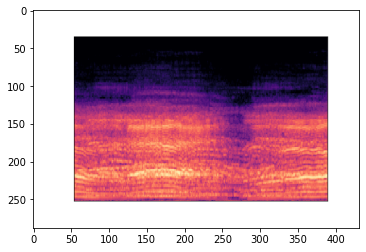

In [16]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread(image_paths[2]) 
  
# Output Images 
plt.imshow(img) 

In [0]:
import tensorflow as tf
labels_one_hot = tf.one_hot(y_train,2)

In [0]:
import pandas as pd
import math

#defining hyperparameters and constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_CLASSES = 2
IMG_SIZE = 128
BATCH_SIZE = 20
EPOCHS = 50
VALIDATION_SPLIT = 0.1
DATASET_SIZE = 1800

In [0]:
def decode_image(image):
    img = tf.image.decode_jpeg(image, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img

def process_image(image_path, label): 
    image = tf.io.read_file(image_path)
    image = decode_image(image)
    return image, label

In [0]:
#creating a tf.data Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels_one_hot)).map(process_image, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE)
split = math.floor(VALIDATION_SPLIT*DATASET_SIZE/BATCH_SIZE)
#splitting between validation and train dataset
val_dataset = dataset.take(split)
train_dataset = dataset.skip(split)

In [0]:
## MODEL : 

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, SpatialDropout2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy

def make_model(image_size, num_classes):
    model = Sequential()
    model.add(Conv2D(16, (5,5), strides=2, activation='relu', padding='same', kernel_regularizer=l2(0.0001), input_shape=(image_size, image_size, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(SpatialDropout2D(0.12))
    model.add(Conv2D(32, (5,5), strides=2, activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(SpatialDropout2D(0.2))
    model.add(Conv2D(64, (5,5), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(0.3))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes))

    model.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model

In [34]:
model = make_model(IMG_SIZE, NUM_CLASSES)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        416       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0

In [35]:
#defining checkpoint directory
checkpoint_path = "/content/Checkpoints/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, )

#training
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[cp_callback])

Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.6395
Epoch 00001: saving model to /content/Checkpoints/cp.ckpt
81/81 [==============================] - 14s 168ms/step - loss: 0.7412 - accuracy: 0.6395 - val_loss: 0.3572 - val_accuracy: 0.9722
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.8988
Epoch 00002: saving model to /content/Checkpoints/cp.ckpt
81/81 [==============================] - 13s 164ms/step - loss: 0.3599 - accuracy: 0.8988 - val_loss: 0.2179 - val_accuracy: 0.9778
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9617
Epoch 00003: saving model to /content/Checkpoints/cp.ckpt
81/81 [==============================] - 13s 165ms/step - loss: 0.2095 - accuracy: 0.9617 - val_loss: 0.1572 - val_accuracy: 0.9667
Epoch 4/50
81/81 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9704
Epoch 00004: saving model to /content/Checkpoints/cp.c

**PREDICTING (TEST DATA)**

In [0]:
image_paths_test = '/content/cough_final/' + X_test.filename.to_numpy()

In [0]:
def process_image_test(image_path): 
    image = tf.io.read_file(image_path)
    image = decode_image(image)
    return image

In [0]:
dataset_test = tf.data.Dataset.from_tensor_slices(image_paths_test).map(process_image_test, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [0]:
predictions = model.predict(dataset_test)

In [0]:
categories = tf.argmax(predictions, axis=1)

In [45]:
categories

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])>

In [47]:
tf.math.confusion_matrix(y_test,categories,2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[195,   1],
       [  3,   1]], dtype=int32)>

In [0]:
dataset_train = tf.data.Dataset.from_tensor_slices(image_paths).map(process_image_test, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [0]:
categories_train = tf.argmax((model.predict(dataset_train)),axis=1)

In [50]:
tf.math.confusion_matrix(y_train,categories_train,2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1763,    1],
       [   7,   29]], dtype=int32)>

In [51]:
data

,filename,label
0,1-100032-A-0.png,0.0
1,1-100038-A-14.png,0.0
2,1-100210-A-36.png,0.0
3,1-100210-B-36.png,0.0
4,1-101296-A-19.png,0.0
...,...,...
1995,5-263831-B-6.png,0.0
1996,5-263902-A-36.png,0.0
1997,5-51149-A-25.png,0.0
1998,5-61635-A-8.png,0.0


In [0]:
image_paths_full = '/content/cough_final/' + data.filename.to_numpy()

In [0]:
dataset_full = tf.data.Dataset.from_tensor_slices(image_paths_full).map(process_image_test, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [0]:
categories_full = tf.argmax(model.predict(dataset_full),axis=1)

In [59]:
tf.math.confusion_matrix(data.label , categories_full,2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1958,    2],
       [  10,   30]], dtype=int32)>

In [0]:
final = data.copy()

In [0]:
final.predictions=categories_full

In [68]:
final

,filename,label
0,1-100032-A-0.png,0.0
1,1-100038-A-14.png,0.0
2,1-100210-A-36.png,0.0
3,1-100210-B-36.png,0.0
4,1-101296-A-19.png,0.0
...,...,...
1995,5-263831-B-6.png,0.0
1996,5-263902-A-36.png,0.0
1997,5-51149-A-25.png,0.0
1998,5-61635-A-8.png,0.0


In [0]:
final=pd.concat([final,pd.DataFrame(categories_full)],axis=1)

In [0]:
final.rename(columns={0 : 'predictions'},inplace=True)

In [84]:
final.label.value_counts()

0.0    1960
1.0      40
Name: label, dtype: int64

In [85]:
final.predictions.value_counts()

0    1968
1      32
Name: predictions, dtype: int64